# Creating Models for San Juan

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
plt.rcParams["font.family"] = "serif"
plt.rcParams["pdf.fonttype"] = 42
sj_new = pd.read_csv("./iq_less_columns.csv")
sj_new.describe()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,520.000000,517.000000,517.000000,517.000000,517.000000,516.000000,516.000000,483.000000,483.000000,506.000000,512.000000,504.000000,520.000000
mean,26.503846,0.263869,0.238783,0.250126,0.266779,88.639117,17.096110,27.530933,10.566197,34.004545,21.196680,62.467262,7.565385
std,15.029450,0.081370,0.076751,0.077354,0.086345,7.583889,1.445769,0.921769,1.535496,1.325261,1.260327,63.245958,10.765478
min,1.000000,0.061729,0.035860,0.029880,0.064183,57.787143,12.111429,21.400000,5.200000,30.100000,14.700000,0.000000,0.000000
25%,13.750000,0.200000,0.179540,0.194743,0.204129,84.295000,16.102857,27.000000,9.500000,33.200000,20.600000,17.200000,1.000000
50%,26.500000,0.263643,0.232971,0.249800,0.262143,90.917143,17.428571,27.600000,10.625000,34.000000,21.300000,45.300000,5.000000
75%,39.250000,0.319971,0.293929,0.302300,0.325150,94.563929,18.180357,28.100000,11.655000,34.900000,22.000000,85.950000,9.000000
max,53.000000,0.508357,0.454429,0.538314,0.546017,98.610000,20.461429,30.800000,15.800000,42.200000,24.200000,543.300000,116.000000


In [3]:
sj_test = pd.read_csv("./iq_test_less_columns.csv")
Year = sj_test['year']
sj_test.drop(['year'], axis=1, inplace=True)
sj_test


,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,26,0.183783,0.142500,0.225129,0.150214,92.581429,17.654286,27.440,10.760,33.8,21.5,11.2
1,27,0.291657,0.272267,0.330700,0.320914,83.885714,16.320000,27.025,9.625,33.0,21.2,8.9
2,28,0.208543,0.366457,0.212629,0.255514,92.057143,18.030000,26.950,10.350,33.4,21.6,22.6
3,29,0.089286,0.063214,0.122057,0.081957,88.970000,15.394286,26.900,9.700,33.3,14.2,4.8
4,30,0.306100,0.327683,0.250086,0.267914,78.610000,15.468571,27.050,11.850,33.5,16.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
151,22,0.301471,0.380029,0.280629,0.383186,89.990000,17.185714,27.400,9.050,32.6,21.8,33.0
152,23,0.247600,0.296343,0.285371,0.350357,93.891429,17.448571,27.520,10.720,33.8,21.4,68.0
153,24,0.238729,0.251029,0.252586,0.249771,94.967143,16.410000,27.200,10.075,32.6,21.6,93.2
154,25,0.310429,0.302700,0.406614,0.403943,89.057143,15.137143,26.700,8.480,32.2,21.8,34.1


The following cell replaces the NaN values with the mean of the cells' values above and below the cell with NaN 

In [4]:
# assume 'df' is a dataframe containing NaN values in multiple columns
for col in sj_new.columns:
    temp = sj_new[col].to_numpy()  # convert the column to a numpy array for faster processing
    
    # fill NaN values with the mean of the previous and next valid values
    mask = sj_new[col].isnull()
    temp[mask] = pd.Series(temp).fillna(method='ffill').add(pd.Series(temp).fillna(method='bfill')).div(2).values[mask]

    # assign the updated values back to the dataframe column
    sj_new[col] = pd.Series(temp)


In [5]:
# assume 'df' is a dataframe containing NaN values in multiple columns
for col in sj_test.columns:
    temp = sj_test[col].to_numpy()  # convert the column to a numpy array for faster processing
    
    # fill NaN values with the mean of the previous and next valid values
    mask = sj_test[col].isnull()
    temp[mask] = pd.Series(temp).fillna(method='ffill').add(pd.Series(temp).fillna(method='bfill')).div(2).values[mask]

    # assign the updated values back to the dataframe column
    sj_test[col] = pd.Series(temp)


In [6]:
threshold_prec = sj_new['station_precip_mm'].quantile(0.975)
threshold_cases = sj_new['total_cases'].quantile(0.975)

# Applying the thresholds into the df
sj_new.loc[sj_new['station_precip_mm'] > threshold_prec, 'station_precip_mm'] = threshold_prec
sj_new.loc[sj_new['total_cases'] > threshold_cases, 'total_cases'] = threshold_cases

min_val = sj_new['total_cases'].min()
max_val = sj_new['total_cases'].max()

print(min_val)
print(max_val)

0
35


In [7]:
sj_new['weekofyear'] =  sj_new['weekofyear'] / 53
sj_new['reanalysis_relative_humidity_percent'] = sj_new['reanalysis_relative_humidity_percent'] / 100
sj_new['reanalysis_specific_humidity_g_per_kg'] =  sj_new['reanalysis_specific_humidity_g_per_kg'] / 20

# select columns to normalize with StandardScaler and MinMaxScaler
columns_minmax = ['station_precip_mm', 'total_cases']
columns_standard = ['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c']

# normalize columns with StandardScaler
scaler_standard = StandardScaler()
sj_new[columns_standard] = scaler_standard.fit_transform(sj_new[columns_standard])

# normalize columns with MinMaxScaler
scaler_minmax = MinMaxScaler()
sj_new[columns_minmax] = scaler_minmax.fit_transform(sj_new[columns_minmax])

In [8]:

# Applying the thresholds into the df
sj_test.loc[sj_test['station_precip_mm'] > threshold_prec, 'station_precip_mm'] = threshold_prec
#sj_test.loc[sj_test['total_cases'] > threshold_cases, 'total_cases'] = threshold_cases


sj_test['weekofyear'] =  sj_test['weekofyear'] / 53
sj_test['reanalysis_relative_humidity_percent'] = sj_test['reanalysis_relative_humidity_percent'] / 100
sj_test['reanalysis_specific_humidity_g_per_kg'] =  sj_test['reanalysis_specific_humidity_g_per_kg'] / 20



# select columns to normalize with StandardScaler and MinMaxScaler
columns_minmax = ['station_precip_mm']
columns_standard = ['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c']

# normalize columns with StandardScaler

sj_test[columns_standard] = scaler_standard.fit_transform(sj_test[columns_standard])

sj_test[columns_minmax] = scaler_minmax.fit_transform(sj_test[columns_minmax])

In [9]:
sj_test.describe()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,156.000000
mean,0.496855,0.266889,0.270574,0.258583,0.282235,0.896060,0.860718,2.027047e-15,3.487239e-17,1.124457e-16,-2.122946e-15,0.159792
std,0.281431,0.074686,0.078552,0.071372,0.084310,0.066551,0.064270,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,0.150230
min,0.018868,0.089286,0.063214,0.098257,0.081957,0.663100,0.686857,-3.505448e+00,-2.885117e+00,-3.343763e+00,-5.372954e+00,0.000000
25%,0.259434,0.214959,0.222436,0.211976,0.217500,0.863164,0.816589,-6.815508e-01,-6.834614e-01,-5.892969e-01,-3.786730e-01,0.052476
50%,0.490566,0.265229,0.269462,0.253164,0.281531,0.914114,0.877607,-7.572831e-02,-6.248157e-02,2.280675e-02,8.954090e-02,0.124528
75%,0.735849,0.319236,0.324557,0.301639,0.347239,0.947425,0.908464,6.992879e-01,6.587018e-01,7.114233e-01,5.967726e-01,0.205778
max,0.981132,0.429986,0.464800,0.453043,0.529043,0.979829,0.979929,2.118332e+00,2.720637e+00,3.389377e+00,1.650254e+00,1.000000


## Selecting target feature

In [10]:
X_sj = sj_new.drop(columns = "total_cases")
Y_sj = sj_new.loc[:, "total_cases"]


X_train = X_sj
Y_train = Y_sj

# X_train, X_test, Y_train, Y_test = train_test_split(X_sj, Y_sj, test_size=0.20)
print("Shape of x_train:", X_train.shape)
print("Shape of y_train:", Y_train.shape)
# print("Shape of x_test:", X_test.shape)
# print("Shape of y_test:", Y_test.shape)

Shape of x_train: (520, 12)
Shape of y_train: (520,)


# Model Choice
## Linear Model Regressor (Baseline)

In [10]:
lr_model = LinearRegression()

lr_model.fit(X_train, Y_train)
#lr_model_pred_test = lr_model.predict(X_test)
lr_model_pred_train = lr_model.predict(X_train)



rmse_lr_train = mean_squared_error(Y_train, lr_model_pred_train, squared=False) 
mae_lr_train = mean_absolute_error(Y_train, lr_model_pred_train)

# rmse_lr_test = mean_squared_error(Y_test, lr_model_pred_test, squared=False) 
# mae_lr_test = mean_absolute_error(Y_test, lr_model_pred_test)

print("RMSE Train: {:.3f}".format(rmse_lr_train))
print("MAE Train: {:.3f}".format(mae_lr_train))

# print("RMSE Test: {:.3f}".format(rmse_lr_test))
# print("MAE Test: {:.3f}".format(mae_lr_test))

RMSE Train: 0.229
MAE Train: 0.164


## Decision Tree Regressor

Uncommment the cell below to perform a gridsearch for the best hyperparameters.

In [11]:
# dt_model = DecisionTreeRegressor()
# # create a grid search object

# param_grid = {
#     "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
#     'max_depth': [5, 10, 15]
# }

# grid_search = GridSearchCV(dt_model, param_grid, cv=5)

# # fit the grid search object to the training data
# grid_search.fit(X_train, Y_train)

# # get the best hyperparameters
# best_params = grid_search.best_params_

# # create a new random forest regressor with the best hyperparameters
# dt_model = DecisionTreeRegressor(max_depth=best_params['max_depth'], criterion=best_params["criterion"])

# # fit the model to the training data
# dt_model.fit(X_train, Y_train)

# # generate predictions on the training data
# dt_train_pred = dt_model.predict(X_train)

# # evaluate the model on the test data
# dt_test_pred = dt_model.predict(X_test)

# rmse_dt = mean_squared_error(Y_test, dt_test_pred, squared=False)
# mae_dt = mean_absolute_error(Y_test, dt_test_pred)

# print("Best Hyperparameters: ", best_params)
# print("RMSE: {:.3f}".format(rmse_dt))
# print("MAE: {:.3f}".format(mae_dt))

In [12]:
dt_model = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)

dt_model.fit(X_train, Y_train)

# generate predictions on the training data
dt_train_pred = dt_model.predict(X_train)

# evaluate the model on the test data
# dt_test_pred = dt_model.predict(X_test)

rmse_dt_train = mean_squared_error(Y_train, dt_train_pred, squared=False)
mae_dt_train = mean_absolute_error(Y_train, dt_train_pred)

print("RMSE Train: {:.3f}".format(rmse_dt_train))
print("MAE Train: {:.3f}".format(mae_dt_train))

# rmse_dt_test = mean_squared_error(Y_test, dt_test_pred, squared=False)
# mae_dt_test = mean_absolute_error(Y_test, dt_test_pred)
# print("RMSE Test: {:.3f}".format(rmse_dt_test))
# print("MAE Test: {:.3f}".format(mae_dt_test))

RMSE Train: 0.153
MAE Train: 0.106


## Random Forest Regressor

Uncommment the cell below to perform a gridsearch for the best hyperparameters.

In [13]:
# # create a random forest regressor object
# rf_model = RandomForestRegressor()

# # define the grid search parameters
# param_grid = {
#     "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [5, 10, 15]
# }

# # create a grid search object
# grid_search = GridSearchCV(rf_model, param_grid, cv=5)

# # fit the grid search object to the training data
# grid_search.fit(X_train, Y_train)

# # get the best hyperparameters
# best_params = grid_search.best_params_

# # create a new random forest regressor with the best hyperparameters
# rf_model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], criterion=best_params["criterion"])

# # fit the model to the training data
# rf_model.fit(X_train, Y_train)

# # generate predictions on the training data
# rf_train_pred = rf_model.predict(X_train)

# # evaluate the model on the test data
# rf_test_pred = rf_model.predict(X_test)

# rmse_rf = mean_squared_error(Y_test, rf_test_pred, squared=False)
# mae_rf = mean_absolute_error(Y_test, rf_test_pred)

# print("Best Hyperparameters: ", best_params)
# print("RMSE: {:.3f}".format(rmse_rf))
# print("MAE: {:.3f}".format(mae_rf))


In [14]:
rf_model = RandomForestRegressor(criterion='friedman_mse', n_estimators=100, max_depth=10)
# fit the model to the training data
rf_model.fit(X_train, Y_train)

# generate predictions on the training data
rf_train_pred = rf_model.predict(X_train)

# evaluate the model on the test data
# rf_test_pred = rf_model.predict(X_test)


rmse_rf_train = mean_squared_error(Y_train, rf_train_pred, squared=False)
mae_rf_train = mean_absolute_error(Y_train, rf_train_pred)

print("RMSE Train: {:.3f}".format(rmse_rf_train))
print("MAE Train: {:.3f}".format(mae_rf_train))

# rmse_rf_test = mean_squared_error(Y_test, rf_test_pred, squared=False)
# mae_rf_test = mean_absolute_error(Y_test, rf_test_pred)
# print("RMSE Test: {:.3f}".format(rmse_rf_test))
# print("MAE Test: {:.3f}".format(mae_rf_test))

RMSE Train: 0.091
MAE Train: 0.069


## Neural Network Regressor

Uncommment the cell below to perform a gridsearch for the best hyperparameters.

In [15]:
# # Define the hyperparameters to search over
# NN_model = MLPRegressor()
# params = {
#     'hidden_layer_sizes': [(64,), (32, 16), (64, 32, 16)],
#     'max_iter': [500, 1000, 2000],
#     'activation': ['relu', 'tanh', 'logistic']
# }

# # Perform a grid search over the hyperparameters
# grid_search = GridSearchCV(NN_model, param_grid=params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, Y_train)

# # Print the best hyperparameters and the associated mean test score
# print("Best hyperparameters:", grid_search.best_params_)

# # Use the best model to make predictions on the training and testing data
# best_model = grid_search.best_estimator_
# Y_pred_train = best_model.predict(X_train)
# Y_pred_test = best_model.predict(X_test)

# # Compute the RMSE and MAE for the training and testing data
# rmse_train = mean_squared_error(Y_train, Y_pred_train, squared=False)
# mae_train = mean_absolute_error(Y_train, Y_pred_train)
# print("RMSE Train: {:.3f}".format(rmse_train))
# print("MAE Train: {:.3f}".format(mae_train))

# rmse_test = mean_squared_error(Y_test, Y_pred_test, squared=False)
# mae_test = mean_absolute_error(Y_test, Y_pred_test)
# print("RMSE Test: {:.3f}".format(rmse_test))
# print("MAE Test: {:.3f}".format(mae_test))

In [11]:
NN_model = MLPRegressor(activation='relu', hidden_layer_sizes=(256, 128, 64), max_iter=500, alpha = 0.0001)

# Train the model on the training data
NN_model.fit(X_train, Y_train)

# Test the model on the testing data and print the accuracy score
Y_pred_NN_train = NN_model.predict(X_train)
# Y_pred_NN_test = NN_model.predict(X_test)

rmse_train_nn = mean_squared_error(Y_train, Y_pred_NN_train, squared=False)
mae_train_nn = mean_absolute_error(Y_train, Y_pred_NN_train)
print("RMSE Train: {:.3f}".format(rmse_train_nn))
print("MAE Train: {:.3f}".format(mae_train_nn))

# rmse_test_nn = mean_squared_error(Y_test, Y_pred_NN_test, squared=False)
# mae_test_nn = mean_absolute_error(Y_test, Y_pred_NN_test)
# print("RMSE Test: {:.3f}".format(rmse_test_nn))
# print("MAE Test: {:.3f}".format(mae_test_nn))

RMSE Train: 0.073
MAE Train: 0.054


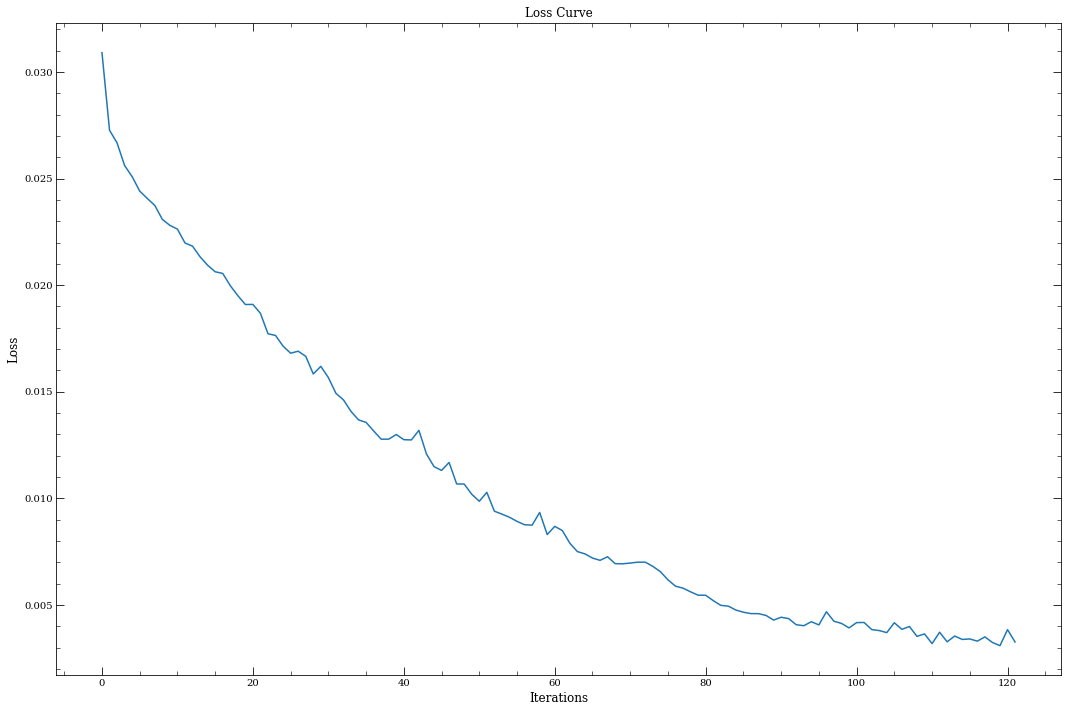

In [12]:
plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1)
ax.minorticks_on()
ax.xaxis.set_ticks_position("both")
ax.tick_params(top=True, right=True, which='major', direction='in', length=8, labelbottom=True, labeltop=False)
ax.tick_params(top=True, right=True, which='minor', direction='in', length=4)
plt.title("Loss Curve", fontsize=12)
plt.xlabel('Iterations', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.plot(NN_model.loss_curve_);

## eXtreme Gradient Boosting (XGB) Regressor

In [18]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# #Define the XGBoost model
# xgb_model = xgb.XGBRegressor(random_state=42)

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 6, 9],
#     'colsample_bytree': [0.5, 0.7, 1.0],
# }

# # Perform grid search
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=[(X_test, Y_test)], verbose=False)

# # Print the best hyperparameters and the corresponding RMSE
# print("Best hyperparameters: ", grid_search.best_params_)
# y_train_pred = grid_search.predict(X_train)
# rmse_train = mean_squared_error(Y_train, y_train_pred, squared=False)
# print(f'RMSE_train: {rmse_train:.2f}')

# test_predictions = grid_search.predict(X_test)
# rmse_test = mean_squared_error(Y_test, test_predictions, squared=False)
# print(f'RMSE_test: {rmse_test:.2f}')

In [19]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
#Define the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, colsample_bytree = 0.7, max_depth=6)

xgb_model.fit(X_train, Y_train, verbose=False)

y_train_pred = xgb_model.predict(X_train)
rmse_train_xgb = mean_squared_error(Y_train, y_train_pred, squared=False)
mae_train_xgb = mean_absolute_error(Y_train, y_train_pred)
print(f'RMSE Train: {rmse_train_xgb:.3f}')
print(f'MAE Train: {mae_train_xgb:.3f}')

# y_test_pred = xgb_model.predict(X_test)
# rmse_test_xgb = mean_squared_error(Y_test, y_test_pred, squared=False)
# mae_test_xgb = mean_absolute_error(Y_test, y_test_pred)
# print(f'RMSE Test: {rmse_test_xgb:.3f}')
# print(f'MAE Test: {mae_test_xgb:.3f}')

RMSE Train: 0.062
MAE Train: 0.047


## Plotting of Top Regressor Model

In [20]:
# rmse_train_values = [rmse_lr_train, rmse_dt_train, rmse_rf_train , rmse_train_nn, rmse_train_xgb]
# rmse_test_values = [rmse_lr_test, rmse_dt_test, rmse_rf_test , rmse_test_nn, rmse_test_xgb]

# mae_train_values = [mae_lr_train, mae_dt_train, mae_rf_train , mae_train_nn, mae_train_xgb]
# mae_test_values = [mae_lr_test, mae_dt_test, mae_rf_test , mae_test_nn, mae_test_xgb]

# model_labels = ['Linear Model', 'Decision Tree', 'Random Forest', 'Neural Network', 'XGB']

# train_positions = np.arange(len(model_labels))
# test_positions = train_positions + 0.2  # Add a small offset to separate the bars

# # Set the figure size
# plt.figure(figsize=(18, 12))
# ax1 = plt.subplot(1, 2, 1)
# ax1.bar(train_positions, rmse_train_values, color='lightcoral', width=0.2, label='Train');
# ax1.bar(test_positions, rmse_test_values, color='firebrick', width=0.2, label='Test');
# ax1.set_title('RMSE of Train and Test Sets', fontsize=12)
# ax1.set_ylabel('RMSE', fontsize=12)
# ax1.set_ylim(0,0.25)
# ax1.set_xticks(train_positions + 0.1, model_labels, fontsize=10)
# ax1.legend(loc="best")
# ax1.minorticks_on()
# ax1.xaxis.set_ticks_position("both")
# ax1.tick_params(top=True, right=True, which='major', direction='in', length=8, labelbottom=True, labeltop=False)
# ax1.tick_params(top=True, right=True, which='minor', direction='in', length=4)

# ax2 = plt.subplot(1, 2, 2)
# ax2.bar(train_positions, mae_train_values, color='lightcoral', width=0.2, label='Train');
# ax2.bar(test_positions, mae_test_values, color='firebrick', width=0.2, label='Test');
# ax2.set_title('MAE of Train and Test Sets', fontsize=12)
# ax2.set_ylabel('MAE', fontsize=12)
# ax2.set_ylim(0,0.25)
# ax2.set_xticks(train_positions + 0.1, model_labels, fontsize=10)
# ax2.legend(loc="best")
# ax2.minorticks_on()
# ax2.xaxis.set_ticks_position("both")
# ax2.tick_params(top=True, right=True, which='major', direction='in', length=8, labelbottom=True, labeltop=False)
# ax2.tick_params(top=True, right=True, which='minor', direction='in', length=4)



# # Show the plot
# plt.tight_layout()
# plt.savefig('sj_new_20.pdf')
# plt.show();

In [21]:
# # create scatter plot of predicted vs actual values for test data
# plt.figure(figsize=(18, 12))
# ax = plt.subplot(1, 1, 1)
# plt.scatter(rf_test_pred, Y_test, color="blue")

# slope, intercept = np.polyfit(rf_test_pred, Y_test, 1)
# x = np.linspace(min(rf_test_pred), max(rf_test_pred), 100)
# y = slope * x + intercept

# # create scatter plot of predicted vs actual values for test data
# plt.scatter(rf_test_pred, Y_test, color = "blue")
# plt.plot(x, y, color='red')

# plt.title('Random Forest Regression Model', fontsize = 12)
# plt.xlabel('Predicted Values', fontsize = 12)
# plt.ylabel('Actual Values', fontsize = 12)

# ax.minorticks_on()
# ax.xaxis.set_ticks_position("both")
# ax.tick_params(top=True, right=True, which='major', direction='in', length=8, labelbottom=True, labeltop=False)
# ax.tick_params(top=True, right=True, which='minor', direction='in', length=4)
# plt.tight_layout()
# plt.show();

In [22]:
print(min_val)
print(max_val)

0
35


In [30]:
#predictions = xgb_model.predict(sj_test)

#predictions = rf_model.predict(sj_test)
#predictions = NN_model.predict(X_train)
#predictions = lr_model.predict(sj_test)
predictions = dt_model.predict(sj_test)
predictions = predictions * (max_val - min_val) + min_val

predictions = predictions.astype(int)
week = (sj_test['weekofyear']*53).astype(int)
Year = Year.astype(int)

In [31]:
submission = pd.DataFrame(predictions, columns=["total_cases"])
submission.insert(0, 'city', "iq")
submission.insert(1, 'year', Year)
submission.insert(2, 'weekofyear', week)
submission.reset_index()
submission.to_csv('Submission_iq_dt.csv', index = False)

In [32]:
submission

,city,year,weekofyear,total_cases
0,iq,2010,26,4
1,iq,2010,27,4
2,iq,2010,28,5
3,iq,2010,29,4
4,iq,2010,30,2
...,...,...,...,...
151,iq,2013,22,4
152,iq,2013,23,4
153,iq,2013,24,4
154,iq,2013,25,4
